In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Instacart Aisle FP-Growth").getOrCreate()

df = spark.read.csv("instacart_sample_25m.csv", header=True, inferSchema=True)
df.show(5)


+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id|               aisle|department|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|  593759|     11068|                4|        1|Medium Cheddar Ch...|      21|           16|     packaged cheese|dairy eggs|  51780|   prior|          68|        4|               12|                   7.0|
| 1214222|     10749|                8|        1|Organic Red Bell ...|      83|            4|    fresh vegetables|   produce| 200087|   prior|          10|        4|       

In [3]:
df.printSchema()


root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- aisle: string (nullable = true)
 |-- department: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)



In [14]:
from pyspark.sql.functions import col

short_cycle_orders = df.filter(col("days_since_prior_order") <= 10)
long_cycle_orders = df.filter(col("days_since_prior_order") >= 25)

In [24]:
from pyspark.sql.functions import collect_set
from pyspark.ml.fpm import FPGrowth

# Prepare product baskets
short_product_baskets = (short_cycle_orders
                         .groupBy("order_id")
                         .agg(collect_set("product_name").alias("items")))

long_product_baskets = (long_cycle_orders
                        .groupBy("order_id")
                        .agg(collect_set("product_name").alias("items")))

from pyspark.ml.fpm import FPGrowth

fp_short = FPGrowth(itemsCol="items", minSupport=0.00002, minConfidence=0.05)
model_short = fp_short.fit(short_product_baskets)

fp_long = FPGrowth(itemsCol="items", minSupport=0.00002, minConfidence=0.05)
model_long = fp_long.fit(long_product_baskets)

# Extract rules again
short_rules_df = model_short.associationRules.orderBy("confidence", ascending=False).limit(50).toPandas()
long_rules_df = model_long.associationRules.orderBy("confidence", ascending=False).limit(50).toPandas()


In [25]:
print(short_rules_df.shape)
print(short_rules_df.head())


(2, 5)
                                   antecedent  \
0  [Nonfat Icelandic Style Strawberry Yogurt]   
1                     [Organic Yellow Squash]   

                                        consequent  confidence       lift  \
0  [Icelandic Style Skyr Blueberry Non-fat Yogurt]    0.063559  65.759165   
1                               [Organic Zucchini]    0.050881   9.525129   

    support  
0  0.000032  
1  0.000028  


In [36]:
short_cycle_orders = df.filter((col("days_since_prior_order") >= 7) & (col("days_since_prior_order") <= 10))
long_cycle_orders = df.filter((col("days_since_prior_order") >= 25) & (col("days_since_prior_order") <= 30))


In [37]:
from pyspark.sql.functions import count

# Most frequently ordered products by short-cycle users
top_short_products = (short_cycle_orders
                      .groupBy("product_name")
                      .agg(count("*").alias("count"))
                      .orderBy(col("count").desc())
                      .limit(15)
                      .toPandas())

# Same for long-cycle users
top_long_products = (long_cycle_orders
                     .groupBy("product_name")
                     .agg(count("*").alias("count"))
                     .orderBy(col("count").desc())
                     .limit(15)
                     .toPandas())



<ipython-input-38-e88e46595b60>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="product_name", data=df, palette="viridis")


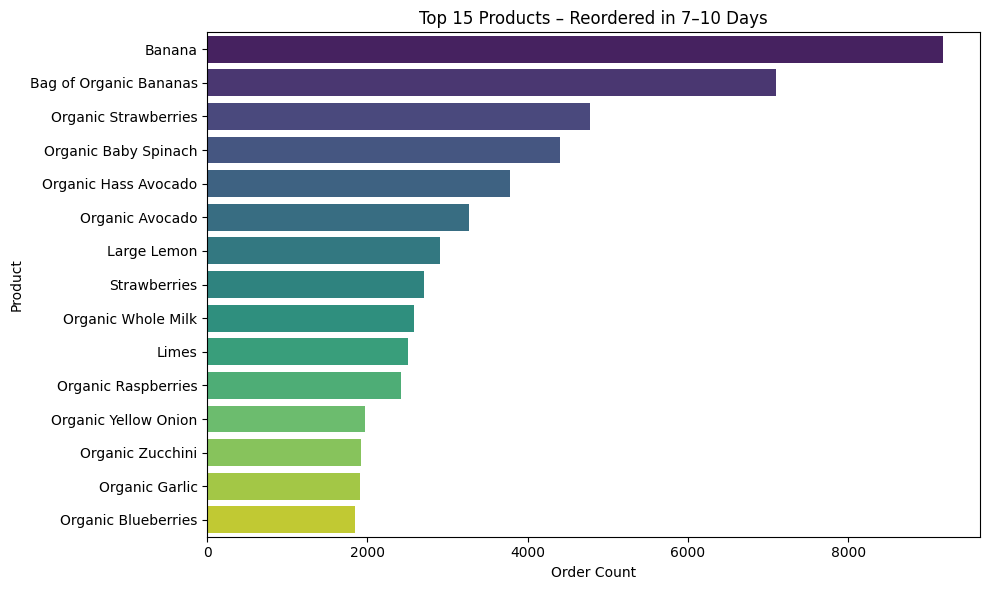

<ipython-input-38-e88e46595b60>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="product_name", data=df, palette="viridis")


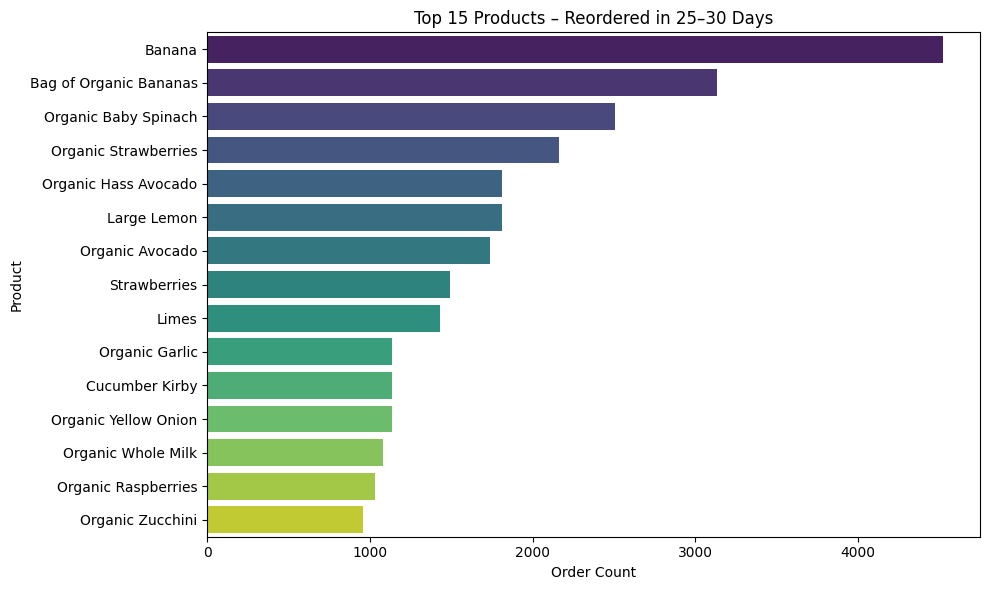

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_products(df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="count", y="product_name", data=df, palette="viridis")
    plt.title(title)
    plt.xlabel("Order Count")
    plt.ylabel("Product")
    plt.tight_layout()
    plt.show()

plot_top_products(top_short_products, "Top 15 Products – Reordered in 7–10 Days")
plot_top_products(top_long_products, "Top 15 Products – Reordered in 25–30 Days")
